# CIFAR10_CNN
An explatory notebook for training deep convolutional neural networks on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) to achieve a 90\%< accuracy. Multiple image augementation techniques, learning rate curves, and architectures are tested.

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Model Parameters

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
LEARNING_RATE = 80 ## This is used as LEARNING_RATE/BATCH_SIZE for a custom learning rate curve with SGD optmizer
WARMUP =  10 ## number of epochs for the warmup phase
WEIGHT_DECAY = 0.000125 ## SGD weight decay
EPOCHS = 35

## Load Dataset

In [ ]:
ds_train = tfds.load('cifar10', split='train', shuffle_files=True, as_supervised=True)
n_train = ds_train.cardinality().numpy() ## Total number of training images
ds_test = tfds.load('cifar10', split='test', as_supervised=True)

for image, label in ds_train:
  IMG_SHAPE = image.shape ## Set the image shape
  break

## Preprocessing and Augmentation
All the images are cast to `float32` data type and rescaled to 0 to 1 scale using `resize_rescale`.
Implementations of `ReflectionPadding2D` and `masking` are also in this cell. These are used for data augmentation later on.

In [ ]:
def resize_rescale(image):
    image = tf.cast(image, dtype=tf.float32)
    return image/255.

class ReflectionPadding2D(tf.keras.layers.Layer):
  def __init__(self, pad=(1, 1)):
    super(ReflectionPadding2D, self).__init__()
    self.pad = pad

  def __call__(self, x):
    w_pad,h_pad = self.pad
    return tf.pad(x, [[h_pad,h_pad], [w_pad,w_pad], [0,0]], mode='REFLECT')

  
def replace_slice(orig, replacement, begin):
  inp_shape = tf.shape(orig) 
  rep_size = tf.shape(replacement)
  padding = tf.stack([tf.squeeze(begin), tf.squeeze((inp_shape - (begin + rep_size)))], axis=1)
  replacement_pad = tf.pad(replacement, padding) 
  mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
  return tf.where(mask, replacement_pad, orig)
  
def masking(x, mask=(1, 1)):
  w_mask,h_mask = mask
  x = tf.expand_dims(x, 0)
  shape = tf.shape(x)
  x0 = tf.random.uniform([shape[0],], 0, shape[1] + 1 - h_mask, dtype=tf.int32)
  y0 = tf.random.uniform([shape[0],], 0, shape[2] + 1 - w_mask, dtype=tf.int32)
  begin = tf.pad(tf.stack([x0, y0], axis=1), [[0, 0], [1, 1]])
  x = replace_slice(x, tf.zeros([shape[0], h_mask, w_mask, shape[-1]], dtype=tf.float32), begin)
  return x[0]

The function to be called on the training dataset:
1. Resize and normalize
2. Shuffle the training data
3. Augmentations:
  1. Reflection padding to prepare for random cropping
  2. Random cropping
  3. Random flipping (only horizontal)
  4. Random cutouts: Randomly cutout an 8x8 section of the image
4. Batch the dataset

In [ ]:
def prepare_data(data, shuffle=False, augment=False):
    # resize and normalize
    data = data.map(lambda x, y: (resize_rescale(x), y), num_parallel_calls=AUTOTUNE)

    #shuffle
    if shuffle:
      data = data.shuffle(BATCH_SIZE)

    #augment
    augments  = tf.keras.Sequential([
               ReflectionPadding2D((4, 4)),
               tf.keras.layers.RandomCrop(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),
               tf.keras.layers.RandomFlip("horizontal"),
               ])
    if augment:
      data = data.map(lambda x, y: (augments(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
      data = data.map(lambda x, y: (masking(x, mask=(8, 8)), y), 
                num_parallel_calls=AUTOTUNE)
      
    return data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

## Create the (augmented) train and test datasets

In [ ]:
ds_train = prepare_data(ds_train, shuffle=True, augment=True)

ds_test = prepare_data(ds_test, shuffle=False, augment=False)

## Visualize a training set data point

tf.Tensor(7, shape=(), dtype=int64)


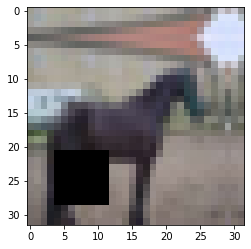

In [ ]:
for image, label in ds_train:
  print(label[0])
  plt.imshow(image[1])
  break

## Define steps per epoch and total __training__ steps

In [ ]:
steps_per_epoch = n_train // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS

## First network
A straight forward CNN with 4 blocks of convolutions and maxpooling. `Dropout` units are also added to prevent overfitting. The head unit is a 128 unit dense layer followed by a 10-unit output.

In [ ]:
class CIFAR_CNN(tf.keras.Model):
  def __init__(self):
    super(CIFAR_CNN, self).__init__()
    self.c1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.c2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.mp1 = tf.keras.layers.MaxPooling2D(pool_size=2)
    self.d1 = tf.keras.layers.Dropout(0.2)

    self.c3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.c4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.mp2 = tf.keras.layers.MaxPooling2D(pool_size=2)
    self.d2 = tf.keras.layers.Dropout(0.3)

    self.c5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn5 = tf.keras.layers.BatchNormalization()
    self.c6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn6 = tf.keras.layers.BatchNormalization()
    self.mp3 = tf.keras.layers.MaxPooling2D(pool_size=2)
    self.d3 = tf.keras.layers.Dropout(0.4)

    self.c7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn7 = tf.keras.layers.BatchNormalization()
    self.c8 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.bn8 = tf.keras.layers.BatchNormalization()
    self.mp4 = tf.keras.layers.MaxPooling2D(pool_size=2)
    self.d4 = tf.keras.layers.Dropout(0.5)

    self.flat = tf.keras.layers.Flatten()
    self.nn1 = tf.keras.layers.Dense(units=128, activation='relu')
    self.d4 = tf.keras.layers.Dropout(0.5)
    self.output_ = tf.keras.layers.Dense(10, activation='softmax')

    self.model = None
    self.history = None
  
  def call(self, input_):
    x = self.c1(input_)
    x = self.bn1(x)
    x = self.c2(x)
    x = self.bn2(x)
    x = self.mp1(x)
    x = self.d1(x)

    x = self.c3(x)
    x = self.bn3(x)
    x = self.c4(x)
    x = self.bn4(x)
    x = self.mp2(x)
    x = self.d2(x)

    x = self.c5(x)
    x = self.bn5(x)
    x = self.c6(x)
    x = self.bn6(x)
    x = self.mp3(x)
    x = self.d3(x)

    x = self.c7(x)
    x = self.bn7(x)
    x = self.c8(x)
    x = self.bn8(x)
    x = self.mp4(x)
    x = self.d4(x)

    x = self.flat(x)
    x = self.nn1(x)
    x = self.d4(x)
    x = self.output_(x)
    return x

## Learning rate scheduler
A simple linear decay for the learning rate with a linear increase for the warmup period. Warmup prevents early over-fitting caused by clustered input images.

In [ ]:
class MyScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self):
    self.initial_learning_rate = 0.01

  def __call__(self, step):
    warmup_steps = steps_per_epoch * WARMUP
    is_warmup = tf.cast(step < warmup_steps, tf.float32)
    decay_lr = tf.keras.optimizers.schedules.PolynomialDecay(self.initial_learning_rate, (total_steps-(steps_per_epoch * WARMUP)), end_learning_rate=0.0, power=1, cycle=False)(step-(steps_per_epoch * WARMUP))
    warmup_lr = self.initial_learning_rate * step / warmup_steps
    return (1.0 - is_warmup) * decay_lr + is_warmup * warmup_lr

Plot of the learning rate curve

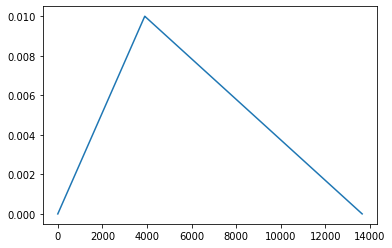

In [ ]:
xs = list(range(total_steps))
ys = [MyScheduler()(i) for i in xs]
plt.plot(xs, ys)

## Define the model, optimizer, and the losses
Using an `Adam` optimizer with the scheduler defined above. The loss is a sparse categorical crossentropy.

In [ ]:
model = CIFAR_CNN()
for test_data in ds_train:
  images, labels = test_data
  run_through = model(images[0:1])
  break
optim = tf.keras.optimizers.Adam(learning_rate=MyScheduler())
losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']
model.compile(optimizer=optim,
                       loss = losses,
                       metrics = metrics
                       )
model.summary()

Model: "cifar_cnn_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          multiple                  896       
                                                                 
 batch_normalization_60 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          multiple                  9248      
                                                                 
 batch_normalization_61 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                       

## Fit the training data

In [ ]:
hist = model.fit(x=ds_train, epochs=50)

Epoch 1/50
391/391 [==============================] - 43s 106ms/step - loss: 2.5384 - accuracy: 0.1956
Epoch 2/50
391/391 [==============================] - 35s 90ms/step - loss: 1.8831 - accuracy: 0.3281
Epoch 3/50
391/391 [==============================] - 35s 90ms/step - loss: 1.6868 - accuracy: 0.4126
Epoch 4/50
391/391 [==============================] - 36s 91ms/step - loss: 1.5677 - accuracy: 0.4761
Epoch 5/50
391/391 [==============================] - 36s 91ms/step - loss: 1.4770 - accuracy: 0.5309
Epoch 6/50
391/391 [==============================] - 36s 91ms/step - loss: 1.4068 - accuracy: 0.5755
Epoch 7/50
391/391 [==============================] - 38s 96ms/step - loss: 1.3444 - accuracy: 0.6155
Epoch 8/50
391/391 [==============================] - 36s 92ms/step - loss: 1.3414 - accuracy: 0.6366
Epoch 9/50
391/391 [==============================] - 36s 91ms/step - loss: 1.3884 - accuracy: 0.6482
Epoch 10/50
391/391 [==============================] - 35s 90ms/step - loss: 1.48

## Loss vs. Epochs graph

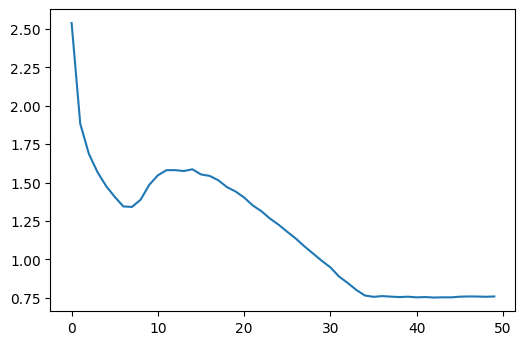

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=100)
ax.plot(hist.history['loss'])
plt.show()

The graph shows an increase in the value of loss at the end of the warmup period which probably indicates a large learning rate. The linear decay fixes the problem.

## Evaluate of test data

In [ ]:
model.evaluate(x=ds_test)

79/79 [==============================] - 2s 19ms/step - loss: 0.6048 - accuracy: 0.8702


[0.6048139929771423, 0.870199978351593]

87\% test accuracy. Not too bad...

## Resnet Architecture
Investigate the effect of residual connections on the performance of our network

In [ ]:
class Resblock(tf.keras.layers.Layer):
  def __init__(self, n_filters, kernel_size=3, strides=1):
    super(Resblock, self).__init__()
    self.c1 = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
  
  def call(self, input_):
    x = self.c1(input_)
    x = self.bn1(x)
    x = self.activation(x)
    return x  

In [ ]:
class Reslayer(tf.keras.layers.Layer):
  def __init__(self, n_filters, kernel_size=3, strides=1):
    super(Reslayer, self).__init__()
    self.c1 = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.a1 = tf.keras.layers.ReLU()
    self.mp1 = tf.keras.layers.MaxPooling2D(pool_size=2)
    self.res1 = Resblock(n_filters, kernel_size, strides)
    self.res2 = Resblock(n_filters, kernel_size, strides)
    self.add = tf.keras.layers.Add()
  
  def call(self, input_):
    x = self.c1(input_)
    x = self.bn1(x)
    x = self.a1(x)
    x = self.mp1(x)
    y = self.res1(x)
    y = self.res2(y)
    x = self.add([x, y])
    return x  

## The new architecture
This is based on the architecture used [here](https://github.com/fenwickslab/fenwicks/blob/master/tutorials/tutorial2_cifar10.ipynb) but not exactly the same.

In [ ]:
class CIFAR_ResNet(tf.keras.Model):
  def __init__(self):
    super(CIFAR_ResNet, self).__init__()
    # prep
    self.c1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation=None)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.a1 = tf.keras.layers.ReLU()

    # layer 1
    self.reslayer1 = Reslayer(128, 3, 1)

    # layer 2
    self.c2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=None)
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.a2 = tf.keras.layers.ReLU()
    self.mp2 = tf.keras.layers.MaxPooling2D(2)

    # layer 3
    self.reslayer2 = Reslayer(512, 3, 1)

    # layer 4
    self.c3 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation=None)
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.a3 = tf.keras.layers.ReLU()
    self.mp3 = tf.keras.layers.MaxPooling2D(2)

    # layer 5
    self.reslayer3 = Reslayer(512, 3, 1)

    # classifier
    self.mpc = tf.keras.layers.GlobalMaxPool2D()
    self.flatten = tf.keras.layers.Flatten()
    self.fc = tf.keras.layers.Dense(10, activation='softmax')

  
  def call(self, input_):
    x = self.c1(input_)
    x = self.bn1(x)
    x = self.a1(x)

    x = self.reslayer1(x)

    x = self.c2(x)
    x = self.bn2(x)
    x = self.a2(x)
    x = self.mp2(x)

    x = self.reslayer2(x)

    x = self.c3(x)
    x = self.bn3(x)
    x = self.a3(x)
    x = self.mp3(x)

    x = self.reslayer3(x)

    x = self.mpc(x)
    x = self.flatten(x)
    x = self.fc(x)
    
    return x

## Learning rate scheduler
Similar to the previous one: Warmup + linear decay

In [ ]:
class MyScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self):
    self.initial_learning_rate = LEARNING_RATE/BATCH_SIZE

  def __call__(self, step):
    warmup_steps = steps_per_epoch * WARMUP
    is_warmup = tf.cast(step < warmup_steps, tf.float32)
    decay_lr = tf.keras.optimizers.schedules.PolynomialDecay(LEARNING_RATE/BATCH_SIZE, (total_steps-(steps_per_epoch * WARMUP)), end_learning_rate=0.0, power=1, cycle=False)(step-(steps_per_epoch * WARMUP))
    warmup_lr = self.initial_learning_rate * step / warmup_steps
    return (1.0 - is_warmup) * decay_lr + is_warmup * warmup_lr

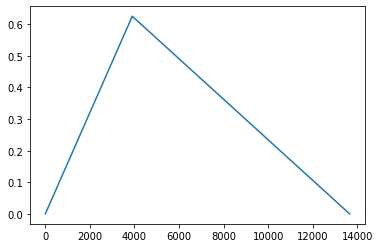

In [ ]:
xs = list(range(total_steps))
ys = [MyScheduler()(i) for i in xs]
plt.plot(xs, ys)

## Define the model
This time we are using `SGD` instead of `Adam`. Everything else is the same.

In [ ]:
model = CIFAR_ResNet()
for test_data in ds_train:
  images, labels = test_data
  run_through = model(images[0:1])
  break
#optim = tf.keras.optimizers.Adam(learning_rate=0.001)
optim = tf.keras.optimizers.SGD(learning_rate=MyScheduler(), momentum=0.9, nesterov=True, decay = WEIGHT_DECAY*BATCH_SIZE)
losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

model.compile(optimizer=optim,
                       loss = losses,
                       metrics = metrics
                       )
model.summary()

Model: "cifar__res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          multiple                  1792      
                                                                 
 batch_normalization_32 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 reslayer (Reslayer)         multiple                  370560    
                                                                 
 conv2d_36 (Conv2D)          multiple                  295168    
                                                                 
 batch_normalization_36 (Bat  multiple                 1024      
 chNormalization)                                   

## Fit to training data

In [ ]:
hist = model.fit(x=ds_train, epochs=EPOCHS)

Epoch 1/35
391/391 [==============================] - 58s 142ms/step - loss: 1.6141 - accuracy: 0.4526
Epoch 2/35
391/391 [==============================] - 53s 135ms/step - loss: 1.0419 - accuracy: 0.6323
Epoch 3/35
391/391 [==============================] - 53s 135ms/step - loss: 0.8372 - accuracy: 0.7054
Epoch 4/35
391/391 [==============================] - 53s 135ms/step - loss: 0.7289 - accuracy: 0.7456
Epoch 5/35
391/391 [==============================] - 53s 134ms/step - loss: 0.6448 - accuracy: 0.7748
Epoch 6/35
391/391 [==============================] - 54s 138ms/step - loss: 0.5891 - accuracy: 0.7945
Epoch 7/35
391/391 [==============================] - 53s 136ms/step - loss: 0.5464 - accuracy: 0.8108
Epoch 8/35
391/391 [==============================] - 52s 134ms/step - loss: 0.5070 - accuracy: 0.8239
Epoch 9/35
391/391 [==============================] - 52s 133ms/step - loss: 0.4713 - accuracy: 0.8360
Epoch 10/35
391/391 [==============================] - 54s 137ms/step - l

## Loss vs. Epoch graph

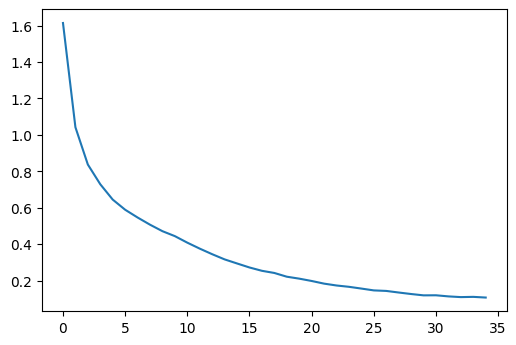

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=100)
ax.plot(hist.history['loss'])
plt.show()

Smooth and plateu-ing. Cool.

## Evaluate of test data

In [ ]:
model.evaluate(x=ds_test)

79/79 [==============================] - 3s 28ms/step - loss: 0.3009 - accuracy: 0.9120


[0.3009231686592102, 0.9120000004768372]

91\% test accuracy! Pretty good!